In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.init as init

import random
from PIL import Image
import pandas as pd
import wandb

from src.CPPN1 import CPPN1
from src.util import get_normalised_coordinate_grid
from sklearn.model_selection import train_test_split

In [2]:
# wandb.init(project="CPPNsquared")

#### Hyperparameters

In [3]:
device = 'cuda'
num_steps = 100
batch_size = 8512
learn_rate = 0.01
momentum = 0.9
num_channels = 3
image_shape = (512, 644)

In [4]:
cppn1 = CPPN1()
cppn1.load_state_dict = torch.load('Checkpoints/CPPN64.pt')
print(cppn1)
# feature maps trasfer learning 

CPPN1(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fce1): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [5]:
# def weights_initialized_randomly(model):
#     for name, param in model.named_parameters():
#         # Check if parameter is trainable and requires gradients
#         if param.requires_grad:
#             # If any parameter has non-zero values, it's not randomly initialized
#             if torch.sum(param.data) != 0:
#                 return False
#     return True

# print(weights_initialized_randomly(cppn1))

#### Map spacial coordinates

In [6]:
parameter_info = []
fc1 = []
full_coords = []
full_weights = []

def normalize_minus1_to_1(tensor):
    min_vals, _ = torch.min(tensor, dim=0)
    max_vals, _ = torch.max(tensor, dim=0)
    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

def spatial_coords(array, layer):

    coords = []
    row1 = []
    row2 = []
    for i in range(array.shape[0]):
        row2.append([layer+1, i])
    for i in range(array.shape[1]):
        row1.append([layer, i])
            
    array = array.flatten("C").tolist()
    # print(array)
    for i in row2:
        for j in row1:
            temp = []
            temp.extend(j)
            temp.extend(i)
            coords.append((temp))
    # coords_array = np.array(coords)
    # coords_array.astype(int)
    # output = np.column_stack((coords_array, array))

    # print(len(output))
    return coords, array
            
    # array.flatten()
    # return np.stack((array, coords))

index = 0
for name, param in cppn1.named_parameters():
    
    # print(name)
    if name.endswith(".weight"):
        
        # print(index)
        # print(param)
        temp_layer = param.detach().numpy() # need to learn more about gradients and why they are required
        # print(temp_layer)

        temp_coords, temp_weights = spatial_coords(temp_layer, index)
        temp_coords = torch.tensor(temp_coords, device=device, dtype=torch.float32)
    
        normal = normalize_minus1_to_1(temp_coords)
        normal = torch.nan_to_num(normal, nan = 0)
        if index == 2:
            print(temp_coords)
            # print(normal)
        full_coords.extend(normal.tolist())
        full_weights.extend(temp_weights)

        index += 1
        # print(fc1.shape[0])

print(full_coords)
# print(full_weights)
    
# layer1_coords, layer1_weights = spatial_coords(fce1, 2)

# print(layer1_arragned)
    
    # getting seemingly random output here 
        

tensor([[ 2.,  0.,  3.,  0.],
        [ 2.,  1.,  3.,  0.],
        [ 2.,  2.,  3.,  0.],
        ...,
        [ 2., 61.,  3., 63.],
        [ 2., 62.,  3., 63.],
        [ 2., 63.,  3., 63.]], device='cuda:0')
[[0.0, -1.0, 0.0, -1.0], [0.0, 1.0, 0.0, -1.0], [0.0, -1.0, 0.0, -0.9682539701461792], [0.0, 1.0, 0.0, -0.9682539701461792], [0.0, -1.0, 0.0, -0.9365079402923584], [0.0, 1.0, 0.0, -0.9365079402923584], [0.0, -1.0, 0.0, -0.9047619104385376], [0.0, 1.0, 0.0, -0.9047619104385376], [0.0, -1.0, 0.0, -0.8730158805847168], [0.0, 1.0, 0.0, -0.8730158805847168], [0.0, -1.0, 0.0, -0.841269850730896], [0.0, 1.0, 0.0, -0.841269850730896], [0.0, -1.0, 0.0, -0.8095238208770752], [0.0, 1.0, 0.0, -0.8095238208770752], [0.0, -1.0, 0.0, -0.7777777910232544], [0.0, 1.0, 0.0, -0.7777777910232544], [0.0, -1.0, 0.0, -0.7460317611694336], [0.0, 1.0, 0.0, -0.7460317611694336], [0.0, -1.0, 0.0, -0.7142857313156128], [0.0, 1.0, 0.0, -0.7142857313156128], [0.0, -1.0, 0.0, -0.682539701461792], [0.0, 1.0, 0

#### Set up CPPN_squared

In [7]:
class CPPN_squared(nn.Module):
    
    def __init__(self):
      super(CPPN_squared, self).__init__()

      self.fc1 = nn.Linear(4, 16)

      self.fc2 = nn.Linear(16, 16)
      self.fce1 = nn.Linear(64, 64)
      self.fce2 = nn.Linear(64,64)

      self.fc3 = nn.Linear(16, 1)     

      self.init_weights()
      
    def init_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Linear):
              # Initialize weights using Xavier initialization
              init.xavier_normal_(m.weight)
              # Initialize biases to zeros
              init.constant_(m.bias, 0)
    
    # defines forward pass
    def forward(self, x):

        x = self.fc1(x)
        x = torch.sin(x)
        # x = F.relu(x)

        x = self.fc2(x)
        x = torch.sin(x)
        # x = F.relu(x)

        # x = self.fce1(x)
        # x = F.relu(x)

        # x = self.fce2(x)
        # x = F.relu(x)

        x = self.fc3(x)
        # x = F.sigmoid(x)

        # returns the output of layer 3 after activation
        return x

In [8]:
CPPN_squared = CPPN_squared()
# wandb.watch(CPPN_squared)
CPPN_squared.to(device)
CPPN_squared.requires_grad_()

# optimiser = torch.optim.SGD(cppn.parameters(), lr=learn_rate, momentum=momentum)
optimiser = torch.optim.Adam(CPPN_squared.parameters(), lr=learn_rate)



criterion = nn.MSELoss(reduction='mean')
# criterion = nn.L1Loss(reduction = "mean")
# criterion = nn.CrossEntropyLoss(reduction='sum')

#### Normalization

In [9]:
def normalize_minus1_to_1(tensor):
    min_vals, _ = torch.min(tensor, dim=0)
    max_vals, _ = torch.max(tensor, dim=0)
    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

In [10]:
normalized_coords_matrix = torch.tensor(full_coords, device=device, dtype=torch.float32)

# Normalize the coordinates matrix along each column
# normalized_coords_matrix = normalize_minus1_to_1(all_xy_coordinates)
# print(normalized_coords_matrix)

all_pixel_values = torch.tensor(full_weights, device=device, dtype=torch.float32)
all_pixel_values = (all_pixel_values + 1)/2
# all_pixel_values = torch.unsqueeze(all_pixel_values, 0)
print(all_pixel_values)

tensor([0.7498, 0.5197, 0.7217,  ..., 0.5036, 0.4628, 0.5172], device='cuda:0')


#### Split training and validation set


In [11]:

# train, test = train_test_split(normalized_coords_matrix, test_size= 0.2, random_state=42)
# train_coords, val_coords, train_pixel_values, val_pixel_values = train_test_split(normalized_coords_matrix, all_pixel_values, test_size=0.1, random_state=42)
# import math
# batch_size = int(batch_size * 0.9)

In [12]:
print(normalized_coords_matrix)

tensor([[ 0.0000, -1.0000,  0.0000, -1.0000],
        [ 0.0000,  1.0000,  0.0000, -1.0000],
        [ 0.0000, -1.0000,  0.0000, -0.9683],
        ...,
        [ 0.0000,  0.9365,  0.0000,  1.0000],
        [ 0.0000,  0.9683,  0.0000,  1.0000],
        [ 0.0000,  1.0000,  0.0000,  1.0000]], device='cuda:0')


In [13]:
num_coords = normalized_coords_matrix.shape[0]
coord_indexes = list(range(0, num_coords))
losses = []
img_list = []
running_loss = 0.0
best_loss = 10000000
best_val_loss = 10000000

target_im_coords = get_normalised_coordinate_grid(image_shape)
target_im_coords = torch.tensor(target_im_coords, dtype = torch.float32)
target_im = Image.open("ACNMW_ACNMW_DA000182-001.jpg").convert("RGB")
target_im = target_im.resize(image_shape)
target_im_vals = np.reshape(target_im, [-1, num_channels]) / 255
target_im_vals = torch.tensor(target_im_vals, device = device, dtype = torch.float32)


for i in range(num_steps):
    optimiser.zero_grad()
    CPPN_squared.zero_grad()

    training_batch_indexes = torch.tensor(np.array(random.sample(range(0, normalized_coords_matrix.shape[0]), batch_size)))

    training_coords_batch = normalized_coords_matrix[training_batch_indexes]

    pixel_values_batch = all_pixel_values[training_batch_indexes]
    pixel_values_batch = pixel_values_batch.unsqueeze(1)

    approx_pixel_values = CPPN_squared(training_coords_batch)

    # torch.save(CPPN_squared.state_dict(), 'temp_model.pt')

    # if i == 0:
    #     with torch.no_grad():
    #         fig1, ax1 = plt.subplot()

    if i % 1 == 0:
        with torch.no_grad():
            prediction = CPPN_squared(normalized_coords_matrix)
            prediction = prediction.flatten(0)

            prediction.mul_(2).sub_(1)
            index_tracker = 0
        
            for name, param in cppn1.named_parameters():
                # print(name)
                if name.endswith(".weight"):
                    # print(param) 
                    temp_tensor = prediction[index_tracker:(index_tracker + param.numel())]
                    # print(param.numel())
                    temp_tensor = torch.reshape(temp_tensor, param.shape)
                    # print(temp_tensor)
                    param.data.copy_(temp_tensor)
                    # print(param.numel())
                    index_tracker += param.numel()
            
                    # print(f"{name} replacement complete")

            torch.save(cppn1.state_dict(), "Checkpoints/CPPNsquaredtest_output.pt")

    new_pred = cppn1(target_im_coords).to(device)

    loss = criterion(new_pred, target_im_vals)
    
    running_loss += loss.item()
    losses.append(loss.item())


    if running_loss < best_loss:
        best_loss = running_loss
        torch.save(CPPN_squared.state_dict(), 'Checkpoints/CPPNsquaredtestbest.pt')
    print(f'step {i}, loss {running_loss:.3f}')
    # wandb.log({"loss": loss.item()})
    running_loss = 0.0

            # wandb.log({"val_loss": val_loss})

            
    #Update model
    loss.backward()
    optimiser.step()
    # wandb.log({"final_weights": CPPN_squared.state_dict()})

step 0, loss 0.049
step 1, loss 0.049
step 2, loss 0.049
step 3, loss 0.049
step 4, loss 0.049
step 5, loss 0.049
step 6, loss 0.049
step 7, loss 0.049
step 8, loss 0.049
step 9, loss 0.049
step 10, loss 0.049
step 11, loss 0.049
step 12, loss 0.049
step 13, loss 0.049
step 14, loss 0.049
step 15, loss 0.049
step 16, loss 0.049
step 17, loss 0.049
step 18, loss 0.049
step 19, loss 0.049
step 20, loss 0.049
step 21, loss 0.049
step 22, loss 0.049
step 23, loss 0.049
step 24, loss 0.049
step 25, loss 0.049
step 26, loss 0.049
step 27, loss 0.049
step 28, loss 0.049
step 29, loss 0.049
step 30, loss 0.049
step 31, loss 0.049
step 32, loss 0.049
step 33, loss 0.049
step 34, loss 0.049
step 35, loss 0.049
step 36, loss 0.049
step 37, loss 0.049
step 38, loss 0.049
step 39, loss 0.049
step 40, loss 0.049
step 41, loss 0.049
step 42, loss 0.049
step 43, loss 0.049
step 44, loss 0.049
step 45, loss 0.049
step 46, loss 0.049
step 47, loss 0.049
step 48, loss 0.049
step 49, loss 0.049
step 50, l

In [14]:
with torch.no_grad():
    torch.set_printoptions(profile="full")
    prediction = CPPN_squared(normalized_coords_matrix)
    prediction = prediction.flatten(0)
    # prediction = prediction * 2 - 1
    print(prediction)

tensor([ 3.9775e-01,  7.9760e-01,  3.8694e-01,  7.8549e-01,  3.7558e-01,
         7.7274e-01,  3.6365e-01,  7.5935e-01,  3.5116e-01,  7.4533e-01,
         3.3810e-01,  7.3069e-01,  3.2448e-01,  7.1544e-01,  3.1030e-01,
         6.9959e-01,  2.9556e-01,  6.8315e-01,  2.8027e-01,  6.6614e-01,
         2.6443e-01,  6.4858e-01,  2.4806e-01,  6.3047e-01,  2.3115e-01,
         6.1185e-01,  2.1373e-01,  5.9272e-01,  1.9580e-01,  5.7311e-01,
         1.7738e-01,  5.5305e-01,  1.5848e-01,  5.3255e-01,  1.3911e-01,
         5.1164e-01,  1.1930e-01,  4.9035e-01,  9.9068e-02,  4.6870e-01,
         7.8427e-02,  4.4672e-01,  5.7403e-02,  4.2444e-01,  3.6017e-02,
         4.0190e-01,  1.4293e-02,  3.7911e-01, -7.7428e-03,  3.5611e-01,
        -3.0065e-02,  3.3294e-01, -5.2646e-02,  3.0962e-01, -7.5459e-02,
         2.8618e-01, -9.8473e-02,  2.6266e-01, -1.2166e-01,  2.3910e-01,
        -1.4499e-01,  2.1552e-01, -1.6843e-01,  1.9195e-01, -1.9195e-01,
         1.6843e-01, -2.1552e-01,  1.4499e-01, -2.3

In [15]:
print(all_pixel_values)

tensor([0.7498, 0.5197, 0.7217, 0.4417, 0.8345, 0.2354, 0.5284, 0.4336, 0.5769,
        0.6428, 0.6924, 0.2800, 0.7029, 0.5665, 0.6205, 0.6897, 0.3920, 0.2374,
        0.7731, 0.6095, 0.5231, 0.2257, 0.3481, 0.8247, 0.7524, 0.6012, 0.2564,
        0.5596, 0.4452, 0.6349, 0.5244, 0.2436, 0.4556, 0.6882, 0.4657, 0.6271,
        0.4509, 0.6557, 0.7445, 0.4415, 0.2650, 0.6365, 0.1662, 0.2423, 0.7664,
        0.5366, 0.5236, 0.4041, 0.1492, 0.6044, 0.7812, 0.7136, 0.8156, 0.5743,
        0.7600, 0.3618, 0.2050, 0.7035, 0.1945, 0.3298, 0.4254, 0.5609, 0.3293,
        0.4120, 0.8418, 0.2205, 0.8446, 0.5270, 0.5674, 0.5013, 0.6628, 0.4436,
        0.3921, 0.4567, 0.2679, 0.3754, 0.3400, 0.3473, 0.6706, 0.6249, 0.8175,
        0.8149, 0.5287, 0.7635, 0.6015, 0.5398, 0.5316, 0.7263, 0.7253, 0.4227,
        0.4769, 0.5303, 0.8202, 0.8381, 0.6452, 0.4040, 0.4568, 0.7341, 0.5371,
        0.8244, 0.1857, 0.8203, 0.3243, 0.2762, 0.1514, 0.1670, 0.5333, 0.4493,
        0.5793, 0.7290, 0.7174, 0.5219, 

Text(0.5, 1.0, 'target')

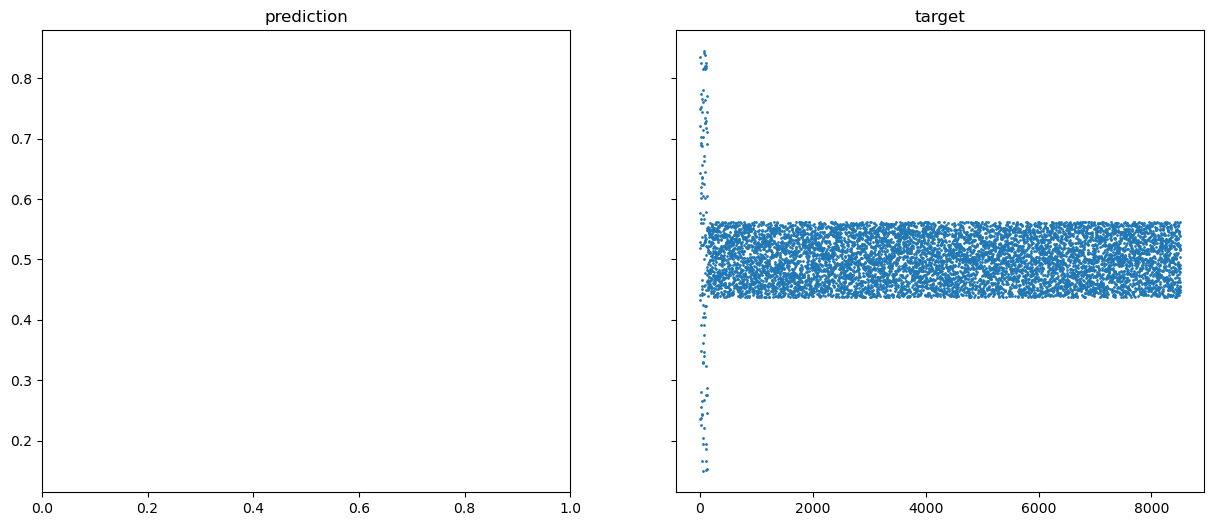

In [18]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize = (15, 6))
# ax[0].set_ylim([0.1, 0.9])
x_values = np.arange(len(prediction.cpu().numpy()))


ax[0].set_title("prediction")
ax[1].scatter(x_values, all_pixel_values.cpu().numpy(), marker='o', s=1)
ax[1].set_title("target")

In [17]:
prediction.mul_(2).sub_(1)
index_tracker = 0
with torch.no_grad():
    for name, param in cppn1.named_parameters():
        # print(name)
        if name.endswith(".weight"):
            # print(param) 
            temp_tensor = prediction[index_tracker:(index_tracker + param.numel())]
            print(param.numel())
            temp_tensor = torch.reshape(temp_tensor, param.shape)
            print(temp_tensor)
            param.data.copy_(temp_tensor)
            # print(param.numel())
            index_tracker += param.numel()
    
            print(f"{name} replacement complete")

    torch.save(cppn1.state_dict(), "Checkpoints/CPPNsquared_output.pt")

128
tensor([[-0.2045,  0.5952],
        [-0.2261,  0.5710],
        [-0.2488,  0.5455],
        [-0.2727,  0.5187],
        [-0.2977,  0.4907],
        [-0.3238,  0.4614],
        [-0.3510,  0.4309],
        [-0.3794,  0.3992],
        [-0.4089,  0.3663],
        [-0.4395,  0.3323],
        [-0.4711,  0.2972],
        [-0.5039,  0.2609],
        [-0.5377,  0.2237],
        [-0.5725,  0.1854],
        [-0.6084,  0.1462],
        [-0.6452,  0.1061],
        [-0.6830,  0.0651],
        [-0.7218,  0.0233],
        [-0.7614, -0.0193],
        [-0.8019, -0.0626],
        [-0.8431, -0.1066],
        [-0.8852, -0.1511],
        [-0.9280, -0.1962],
        [-0.9714, -0.2418],
        [-1.0155, -0.2878],
        [-1.0601, -0.3341],
        [-1.1053, -0.3808],
        [-1.1509, -0.4276],
        [-1.1969, -0.4747],
        [-1.2433, -0.5218],
        [-1.2900, -0.5690],
        [-1.3369, -0.6161],
        [-1.3839, -0.6631],
        [-1.4310, -0.7100],
        [-1.4782, -0.7567],
        [-1.5253